## **FASE IV: MODELADO**

### **KNN (K-Nearest Neighbors, Regresión)**

In [16]:
# Librerías de SciKit para procesamiento con CPU

import pandas as pd
from sklearn.model_selection import train_test_split

# Carga de parquet preprocesado
path = 'monopoly_cleaned_parquet'
monopoly = pd.read_parquet(path)

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Asignar variables objetivo
X = pd.DataFrame(monopoly.drop(columns=['Renta']))
X.head()

,Subsegmento,Sexo,Region,Edad,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,ColL2AC_avg,ColL2CC_avg,ColMx_avg,PagoNac_avg,PagoInt_avg,EeccNac_avg,EeccInt_avg,UsoL1_avg,UsoL2_avg,UsoLI_avg
0,160.0,1.0,13.0,43.0,130.0,1.0,1.0,0.0,0.0,1.0,...,0.0,34699.666667,0.0000,29333.333333,0.0,908079.416667,0.000000,913045.583333,53874.250000,0.000000
1,160.0,0.0,13.0,46.0,69.0,1.0,0.0,0.0,0.0,1.0,...,0.0,17597.250000,45699.2125,167416.666667,0.0,460136.500000,58.904167,428734.833333,119963.916667,84.508333
2,170.0,0.0,13.0,45.0,24.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.000000,0.0000,68325.750000,0.0,8510.750000,0.000000,25294.500000,0.000000,0.000000
3,151.0,0.0,13.0,46.0,134.0,0.0,1.0,0.0,1.0,0.0,...,0.0,2706.500000,0.0000,57083.333333,0.0,341916.833333,0.000000,344417.500000,31825.250000,0.000000
4,170.0,0.0,13.0,46.0,116.0,0.0,1.0,1.0,0.0,1.0,...,0.0,6227.666667,0.0000,291317.166667,0.0,291684.500000,0.000000,83849.250000,402597.666667,0.000000


In [18]:
y = pd.DataFrame(monopoly['Renta'])
y.head()

,Renta
0,601932.8
1,143640.0
2,929106.0
3,172447.0
4,805250.0


----

In [33]:
# Librerías de Nvidia para procesamiento con GPU
import cudf

# Carga de parquet preprocesado
path = 'monopoly_cleaned_parquet'
monopoly = cudf.read_parquet(path)

import warnings
warnings.filterwarnings('ignore')

In [34]:
monopoly.head()

,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,...,ColL2AC_avg,ColL2CC_avg,ColMx_avg,PagoNac_avg,PagoInt_avg,EeccNac_avg,EeccInt_avg,UsoL1_avg,UsoL2_avg,UsoLI_avg
0,160.0,1.0,13.0,43.0,601932.8,130.0,1.0,1.0,0.0,0.0,...,0.0,34699.666667,0.0000,29333.333333,0.0,908079.416667,0.000000,913045.583333,53874.250000,0.000000
1,160.0,0.0,13.0,46.0,143640.0,69.0,1.0,0.0,0.0,0.0,...,0.0,17597.250000,45699.2125,167416.666667,0.0,460136.500000,58.904167,428734.833333,119963.916667,84.508333
2,170.0,0.0,13.0,45.0,929106.0,24.0,1.0,1.0,0.0,0.0,...,0.0,0.000000,0.0000,68325.750000,0.0,8510.750000,0.000000,25294.500000,0.000000,0.000000
3,151.0,0.0,13.0,46.0,172447.0,134.0,0.0,1.0,0.0,1.0,...,0.0,2706.500000,0.0000,57083.333333,0.0,341916.833333,0.000000,344417.500000,31825.250000,0.000000
4,170.0,0.0,13.0,46.0,805250.0,116.0,0.0,1.0,1.0,0.0,...,0.0,6227.666667,0.0000,291317.166667,0.0,291684.500000,0.000000,83849.250000,402597.666667,0.000000


In [35]:
# Asignar variables objetivo
X = monopoly.drop(columns=['Renta'])
X.head()

,Subsegmento,Sexo,Region,Edad,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,...,ColL2AC_avg,ColL2CC_avg,ColMx_avg,PagoNac_avg,PagoInt_avg,EeccNac_avg,EeccInt_avg,UsoL1_avg,UsoL2_avg,UsoLI_avg
0,160.0,1.0,13.0,43.0,130.0,1.0,1.0,0.0,0.0,1.0,...,0.0,34699.666667,0.0000,29333.333333,0.0,908079.416667,0.000000,913045.583333,53874.250000,0.000000
1,160.0,0.0,13.0,46.0,69.0,1.0,0.0,0.0,0.0,1.0,...,0.0,17597.250000,45699.2125,167416.666667,0.0,460136.500000,58.904167,428734.833333,119963.916667,84.508333
2,170.0,0.0,13.0,45.0,24.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.000000,0.0000,68325.750000,0.0,8510.750000,0.000000,25294.500000,0.000000,0.000000
3,151.0,0.0,13.0,46.0,134.0,0.0,1.0,0.0,1.0,0.0,...,0.0,2706.500000,0.0000,57083.333333,0.0,341916.833333,0.000000,344417.500000,31825.250000,0.000000
4,170.0,0.0,13.0,46.0,116.0,0.0,1.0,1.0,0.0,1.0,...,0.0,6227.666667,0.0000,291317.166667,0.0,291684.500000,0.000000,83849.250000,402597.666667,0.000000


In [36]:
y = monopoly['Renta']
y.head()

0    601932.8
1    143640.0
2    929106.0
3    172447.0
4    805250.0
Name: Renta, dtype: float64

#### **Modelo N°1.1***

*Debido a la pequeña diferencia entre librerias usadas (CUDA y SciKit) se crearán dos modelos que servirán como base para cada una, respectivamente. Los modelos marcados como ".1" son creados con las librerías de Nvidia, mientras que los modelos marcados como ".2" son creados con las librerías de SciKit.

In [37]:
from cuml.neighbors import KNeighborsRegressor

# Creación del modelo
knn_1 = KNeighborsRegressor(n_neighbors=5)

In [38]:
knn_1 = knn_1.fit(X, y)

In [39]:
Y_hat = knn_1.predict(X)

In [40]:
# Evaluación del modelo
from cuml.metrics import mean_squared_error
from cuml.metrics import r2_score
from cuml.metrics import mean_absolute_error
from math import sqrt


MAE_1 = mean_absolute_error(y, Y_hat)
MSE_1 = mean_squared_error(y, Y_hat)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(y, Y_hat)

print("MAE: %.2f" % MAE_1 )
print("MSE: %.2f" % MSE_1)
print("RMSE: %.2f" % RMSE_1)
print('r2: %.2f' % r2_1)

MAE: 168665.58
MSE: 79441744940.96
RMSE: 281854.12
r2: 0.45


#### **Modelo N°1.2** 

In [19]:
from sklearn.neighbors import KNeighborsRegressor as skKNN

# Creación del modelo
knn_1_1 = skKNN(n_neighbors=5)

In [20]:
knn_1_1 = knn_1_1.fit(X, y)

In [21]:
#Ŷ (Y gorro) = Y_hat
Y_hat = knn_1_1.predict(X)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

MAE_1_1 = mean_absolute_error(y, Y_hat)
MSE_1_1 = mean_squared_error(y, Y_hat)
RMSE_1_1 = sqrt(MSE_1_1)
r2_1_1 = r2_score(y, Y_hat)

print("MAE: %.2f" % MAE_1_1 )
print("MSE: %.2f" % MSE_1_1)
print("RMSE: %.2f" % RMSE_1_1)
print('r2: %.2f' % r2_1_1)

MAE: 168668.59
MSE: 79442545064.15
RMSE: 281855.54
r2: 0.45


#### **Modelo N°2.1**

In [41]:
from cuml.model_selection import train_test_split

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=52)

In [42]:
knn_2 = KNeighborsRegressor(n_neighbors=7, metric='euclidean', weights='uniform')

In [43]:
knn_2 = knn_2.fit(X_train, y_train)

In [44]:
Y_hat = knn_2.predict(X_test)

In [45]:
MAE_2 = mean_absolute_error(y_test, Y_hat)
MSE_2 = mean_squared_error(y_test, Y_hat)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(y_test, Y_hat)

print("MAE: %.2f" % MAE_2 )
print("MSE: %.2f" % MSE_2)
print("RMSE: %.2f" % RMSE_2)
print('r2: %.2f' % r2_2)

MAE: 201465.16
MSE: 104804196651.52
RMSE: 323734.76
r2: 0.21


#### **Modelo N°2.2**

In [23]:
from sklearn.model_selection import train_test_split

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=52)

In [24]:
knn_2_2 = skKNN(n_neighbors=7, metric='euclidean', weights='distance')

In [25]:
knn_2_2 = knn_2_2.fit(X_train, y_train)

In [26]:
Y_hat = knn_2_2.predict(X_test)

In [27]:
MAE_2_2 = mean_absolute_error(y_test, Y_hat)
MSE_2_2 = mean_squared_error(y_test, Y_hat)
RMSE_2_2 = sqrt(MSE_2_2)
r2_2_2 = r2_score(y_test, Y_hat)

print("MAE: %.2f" % MAE_2_2 )
print("MSE: %.2f" % MSE_2_2)
print("RMSE: %.2f" % RMSE_2_2)
print('r2: %.2f' % r2_2_2)

MAE: 199589.17
MSE: 104269525289.61
RMSE: 322907.92
r2: 0.21


#### **Modelo N°3**

In [46]:
knn_3 = KNeighborsRegressor(n_neighbors=12, metric='minkowski', p=5)

In [47]:
knn_3 = knn_3.fit(X_train, y_train)
Y_hat = knn_3.predict(X_test)

In [48]:
MAE_3 = mean_absolute_error(y_test, Y_hat)
MSE_3 = mean_squared_error(y_test, Y_hat)
RMSE_3 = sqrt(MSE_3)
r2_3 = r2_score(y_test, Y_hat)

print("MAE: %.2f" % MAE_3)
print("MSE: %.2f" % MSE_3)
print("RMSE: %.2f" % RMSE_3)
print('r2: %.2f' % r2_3)

MAE: 202024.48
MSE: 102324658332.41
RMSE: 319882.26
r2: 0.22


#### **Modelo N°4**

In [49]:
knn_4 = KNeighborsRegressor(n_neighbors=9, metric='manhattan', weights='uniform')

In [50]:
knn_4 = knn_4.fit(X_train, y_train)
Y_hat = knn_4.predict(X_test)

In [51]:
MAE_4 = mean_absolute_error(y_test, Y_hat)
MSE_4 = mean_squared_error(y_test, Y_hat)
RMSE_4 = sqrt(MSE_4)
r2_4 = r2_score(y_test, Y_hat)

print("MAE: %.2f" % MAE_4)
print("MSE: %.2f" % MSE_4)
print("RMSE: %.2f" % RMSE_4)
print('r2: %.2f' % r2_4)

MAE: 202774.46
MSE: 104004751681.07
RMSE: 322497.68
r2: 0.21


#### **Modelo N°5**

In [29]:
from sklearn.model_selection import GridSearchCV

# Definir la lista de hiperparámetros a probar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 12],  # Valores de K
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métricas de distancia
}

# Crear el modelo KNN Regressor
knn = skKNN()

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)  # X_train y y_train son tus datos de entrenamiento

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_params

{'metric': 'euclidean', 'n_neighbors': 12}

A partir del GridSearch anterior, se crea un modelo con los hiperparámetros dados. 'euclidean' y 'n_neighbors: 12'"

In [30]:
# Crear un nuevo modelo KNN Regressor con los mejores parámetros
best_k = best_params['n_neighbors']  # Mejor valor de K
best_metric = best_params['metric']  # Mejor métrica de distancia

knn_5 = skKNN(n_neighbors=best_k, metric=best_metric, weights='distance')

In [31]:
knn_5 = knn_5.fit(X_train, y_train)
Y_hat = knn_5.predict(X_test)

In [70]:
MAE_5 = mean_absolute_error(y_test, Y_hat)
MSE_5 = mean_squared_error(y_test, Y_hat)
RMSE_5 = sqrt(MSE_5)
r2_5 = r2_score(y_test, Y_hat)

print("MAE: %.2f" % MAE_5)
print("MSE: %.2f" % MSE_5)
print("RMSE: %.2f" % RMSE_5)
print('r2: %.2f' % r2_5)

MAE: 202774.46
MSE: 104004751681.07
RMSE: 322497.68
r2: 0.21


**Comparación de modelos**

In [86]:
# Comparamos todos los modelos y elegimos el mejor

knn_best = pd.DataFrame({
    'Modelo': ['KNN_1', 'KNN_1_1', 'KNN_2', 'KNN_2_2', 'KNN_3', 'KNN_4', 'KNN_5'],
    'MAE': [MAE_1.get(), MAE_1_1, MAE_2.get(), MAE_2_2, MAE_3.get(), MAE_4.get(), MAE_5.get()],
    'MSE': [MSE_1.get(), MSE_1_1, MSE_2.get(), MSE_2_2, MSE_3.get(), MSE_4.get(), MSE_5.get()],
    'RMSE': [RMSE_1, RMSE_1_1, RMSE_2, RMSE_2_2, RMSE_3, RMSE_4, RMSE_5],
    'r2': [r2_1, r2_1_1, r2_2, r2_2_2, r2_3, r2_4, r2_5],
    })

knn_best

,Modelo,MAE,MSE,RMSE,r2
0,KNN_1,168665.57552030723,79441744940.95837,281854.119964,0.446528
1,KNN_1_1,168668.587339,79442545064.147537,281855.539353,0.446522
2,KNN_2,201465.16447736553,104804196651.51784,323734.762810,0.206001
3,KNN_2_2,199589.174232,104269525289.612473,322907.920760,0.211539
4,KNN_3,202024.47722751836,102324658332.41467,319882.256983,0.224786
5,KNN_4,202774.46379154647,104004751681.06624,322497.677017,0.212058
6,KNN_5,202774.46379154647,104004751681.06624,322497.677017,0.212058


El modelo que más ajuste y menor error tiene, es el modelo N°4, que se considerará como el "modelo ganador".

In [89]:
import joblib as jb

# Guardar el modelo
jb.dump(knn_3, "../MachineLearning-003D/models/knn3_regress.pkl")

['../MachineLearning-003D/models/knn3_regress.pkl']

### **KNN (K-Nearest Neighbors, Clasificación)**

In [1]:
# Librerías de SciKit para procesamiento con CPU

import pandas as pd
from sklearn.model_selection import train_test_split

# Carga de parquet preprocesado
path = 'monopoly_cleaned_parquet'
monopoly = pd.read_parquet(path)

import warnings
warnings.filterwarnings('ignore')

**Definición de variables objetivo (SciKit)**

In [2]:
X = pd.DataFrame(monopoly.drop(columns=['Internauta']))
X.head()

,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Adicional,Dualidad,Monoproducto,Ctacte,...,ColL2AC_avg,ColL2CC_avg,ColMx_avg,PagoNac_avg,PagoInt_avg,EeccNac_avg,EeccInt_avg,UsoL1_avg,UsoL2_avg,UsoLI_avg
0,160.0,1.0,13.0,43.0,601932.8,130.0,1.0,0.0,0.0,1.0,...,0.0,34699.666667,0.0000,29333.333333,0.0,908079.416667,0.000000,913045.583333,53874.250000,0.000000
1,160.0,0.0,13.0,46.0,143640.0,69.0,0.0,0.0,0.0,1.0,...,0.0,17597.250000,45699.2125,167416.666667,0.0,460136.500000,58.904167,428734.833333,119963.916667,84.508333
2,170.0,0.0,13.0,45.0,929106.0,24.0,1.0,0.0,0.0,1.0,...,0.0,0.000000,0.0000,68325.750000,0.0,8510.750000,0.000000,25294.500000,0.000000,0.000000
3,151.0,0.0,13.0,46.0,172447.0,134.0,1.0,0.0,1.0,0.0,...,0.0,2706.500000,0.0000,57083.333333,0.0,341916.833333,0.000000,344417.500000,31825.250000,0.000000
4,170.0,0.0,13.0,46.0,805250.0,116.0,1.0,1.0,0.0,1.0,...,0.0,6227.666667,0.0000,291317.166667,0.0,291684.500000,0.000000,83849.250000,402597.666667,0.000000


In [4]:
y = pd.DataFrame(monopoly['Internauta'])
y.head()

,Internauta
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


In [5]:
y.groupby('Internauta').size()

Internauta
0.0    16142
1.0    34979
dtype: int64

Podemos ver que las variables se encuentran desbalanceadas.

#### **Modelo N°1**

In [6]:
from sklearn.neighbors import KNeighborsClassifier as skKNN_C

# Separación de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=52)

# Creación del modelo
knn_1_2C = skKNN_C(n_neighbors=3)
knn_1_2C = knn_1_2C.fit(X_train, y_train)

In [7]:
# Estimación de Ŷ (Y gorro)
Y_hat = knn_1_2C.predict(X_test)

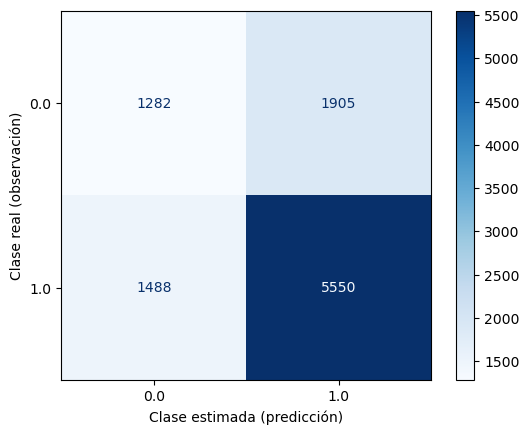

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#Matriz de Confusion
matriz = confusion_matrix(y_test, Y_hat)

grafico = ConfusionMatrixDisplay(confusion_matrix=matriz,display_labels=knn_1_2C.classes_)
grafico.plot(cmap=plt.cm.Blues,values_format='g')
plt.xlabel('Clase estimada (predicción)')
plt.ylabel('Clase real (observación)')
plt.show()

In [9]:
VN, FP, FN, VP = matriz.ravel()
Tasa_FP_1 = FP/(FP+VN)
Tasa_FN_1 = FN/(FN+VP)

print('METRICAS DE DESEMPEÑO | MDL1_CF')
print("--------------------------------------")
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')
print("--------------------------------------")
print("Error tipo I: %.2f" % Tasa_FP_1)
print("Error tipo II: %.2f" % Tasa_FN_1)

METRICAS DE DESEMPEÑO | MDL1_CF
--------------------------------------
Verdaderos positivos (VP): 5550
Falsos positivos (FP): 1905
Verdaderos negativos (VN): 1282
Falsos negativos (FN): 1488
--------------------------------------
Error tipo I: 0.60
Error tipo II: 0.21


In [10]:
#Accuracy
SCORE_1_2 = knn_1_2C.score(X_test, y_test)
print("ACCURACY: %.2f" % SCORE_1_2)

#F1-Score
f1_1_2 = f1_score(y_test, Y_hat)
print("F1-Score: %.2f" % f1_1_2)

ACCURACY: 0.67
F1-Score: 0.77


In [11]:
#Metricas
print(classification_report(y_test, Y_hat))

              precision    recall  f1-score   support

         0.0       0.46      0.40      0.43      3187
         1.0       0.74      0.79      0.77      7038

    accuracy                           0.67     10225
   macro avg       0.60      0.60      0.60     10225
weighted avg       0.66      0.67      0.66     10225



#### **Modelo N°2**

In [12]:
knn_2_2C = skKNN_C(n_neighbors=9, p=1, weights='distance')
knn_2_2C = knn_2_2C.fit(X_train, y_train)

In [13]:
Y_hat = knn_2_2C.predict(X_test)

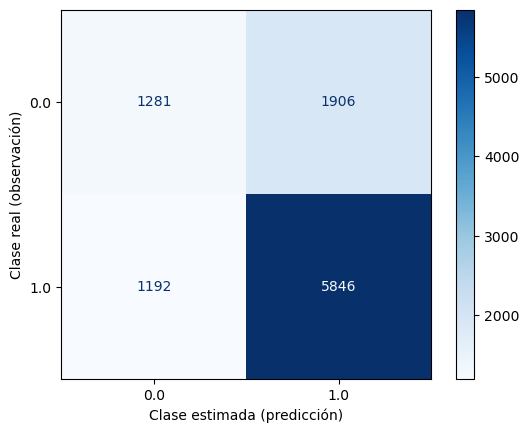

In [14]:
#Matriz de Confusion
matriz = confusion_matrix(y_test, Y_hat)

grafico = ConfusionMatrixDisplay(confusion_matrix=matriz,display_labels=knn_2_2C.classes_)
grafico.plot(cmap=plt.cm.Blues,values_format='g')
plt.xlabel('Clase estimada (predicción)')
plt.ylabel('Clase real (observación)')
plt.show()

In [15]:
VN, FP, FN, VP = matriz.ravel()
Tasa_FP_2_2 = FP/(FP+VN)
Tasa_FN_2_2 = FN/(FN+VP)

print('METRICAS DE DESEMPEÑO | MDL1_CF')
print("--------------------------------------")
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')
print("--------------------------------------")
print("Error tipo I: %.2f" % Tasa_FP_2_2)
print("Error tipo II: %.2f" % Tasa_FN_2_2)

METRICAS DE DESEMPEÑO | MDL1_CF
--------------------------------------
Verdaderos positivos (VP): 5846
Falsos positivos (FP): 1906
Verdaderos negativos (VN): 1281
Falsos negativos (FN): 1192
--------------------------------------
Error tipo I: 0.60
Error tipo II: 0.17


In [16]:
#Accuracy
SCORE_2_2 = knn_2_2C.score(X_test, y_test)
print("ACCURACY: %.2f" % SCORE_2_2)

#F1-Score
f1_2_2 = f1_score(y_test, Y_hat)
print("F1-Score: %.2f" % f1_2_2)

ACCURACY: 0.70
F1-Score: 0.79


In [17]:
print(classification_report(y_test, Y_hat))

              precision    recall  f1-score   support

         0.0       0.52      0.40      0.45      3187
         1.0       0.75      0.83      0.79      7038

    accuracy                           0.70     10225
   macro avg       0.64      0.62      0.62     10225
weighted avg       0.68      0.70      0.69     10225



#### **Modelo N°3**

In [47]:
knn_3C = skKNN_C(n_neighbors=12, p=3, weights='distance', algorithm='brute')
knn_3C = knn_3C.fit(X_train, y_train)

In [48]:
Y_hat = knn_3C.predict(X_test)

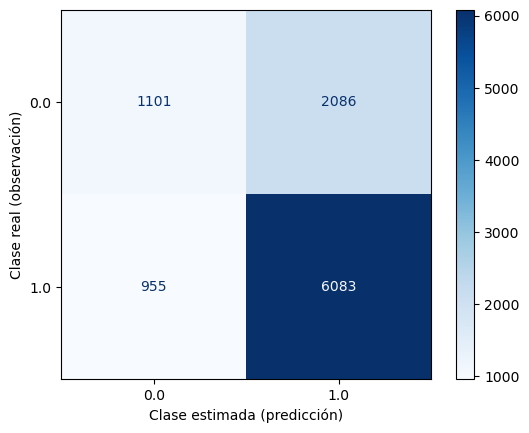

In [49]:
#Matriz de Confusion
matriz = confusion_matrix(y_test, Y_hat)

grafico = ConfusionMatrixDisplay(confusion_matrix=matriz,display_labels=knn_3C.classes_)
grafico.plot(cmap=plt.cm.Blues,values_format='g')
plt.xlabel('Clase estimada (predicción)')
plt.ylabel('Clase real (observación)')
plt.show()

In [50]:
VN, FP, FN, VP = matriz.ravel()
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')

Verdaderos positivos (VP): 6083
Falsos positivos (FP): 2086
Verdaderos negativos (VN): 1101
Falsos negativos (FN): 955


In [51]:
#Tasa de error
Tasa_FP_3 = FP/(FP+VN)
Tasa_FN_3 = FN/(FN+VP)

print("Error tipo I: %.2f" % Tasa_FP_3)
print("Error tipo II: %.2f" % Tasa_FN_3)

Error tipo I: 0.65
Error tipo II: 0.14


In [52]:
#Accuracy
SCORE_3 = knn_3C.score(X_test, y_test)
print("ACCURACY: %.2f" % SCORE_3)

#F1-Score
f1_3 = f1_score(y_test, Y_hat)
print("F1-Score: %.2f" % f1_3)

ACCURACY: 0.70
F1-Score: 0.80


In [53]:
#Metricas
print(classification_report(y_test, Y_hat))

              precision    recall  f1-score   support

         0.0       0.54      0.35      0.42      3187
         1.0       0.74      0.86      0.80      7038

    accuracy                           0.70     10225
   macro avg       0.64      0.60      0.61     10225
weighted avg       0.68      0.70      0.68     10225



#### **Modelo N°4**

In [38]:
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Definir la lista de hiperparámetros a probar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 12],  # Valores de K
    'p': [1, 2, 3, 4, 5],  # Valores de p
    'weights': ['uniform', 'distance'],  # Valores de los pesos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Valores del algoritmo    
}

y_train = np.ravel(y_train)

# Crear el modelo KNN Classifier
knn = skKNN_C(weights='distance')

# Realizar la búsqueda en cuadrícula
grid_search = HalvingGridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_params

{'algorithm': 'kd_tree', 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}

In [54]:
knn_4C = skKNN_C(algorithm='kd_tree', n_neighbors=12, p=2, weights='distance')
knn_4C = knn_4C.fit(X_train, y_train)

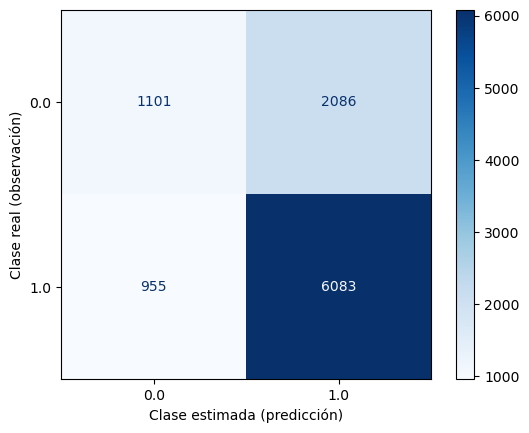

In [55]:
#Matriz de Confusion
matriz = confusion_matrix(y_test, Y_hat)

grafico = ConfusionMatrixDisplay(confusion_matrix=matriz,display_labels=knn_4C.classes_)
grafico.plot(cmap=plt.cm.Blues,values_format='g')
plt.xlabel('Clase estimada (predicción)')
plt.ylabel('Clase real (observación)')
plt.show()

In [56]:
VN, FP, FN, VP = matriz.ravel()
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')

Verdaderos positivos (VP): 6083
Falsos positivos (FP): 2086
Verdaderos negativos (VN): 1101
Falsos negativos (FN): 955


In [57]:
#Tasa de error
Tasa_FP_4 = FP/(FP+VN)
Tasa_FN_4 = FN/(FN+VP)

print("Error tipo I: %.2f" % Tasa_FP_4)
print("Error tipo II: %.2f" % Tasa_FN_4)

Error tipo I: 0.65
Error tipo II: 0.14


In [58]:
#Accuracy
SCORE_4 = knn_4C.score(X_test, y_test)
print("ACCURACY: %.2f" % SCORE_4)

#F1-Score
f1_4 = f1_score(y_test, Y_hat)
print("F1-Score: %.2f" % f1_4)

ACCURACY: 0.70
F1-Score: 0.80


In [59]:
tabla = pd.DataFrame({'Métrica':['Error Tipo I:','Error Tipo II:','Accuracy:','F1-Score'],
                      'Modelo 1':[Tasa_FP_1,Tasa_FN_1,SCORE_1_2,f1_1_2],
                      'Modelo 2':[Tasa_FP_2_2,Tasa_FN_2_2,SCORE_2_2,f1_2_2],
                      'Modelo 3':[Tasa_FP_3,Tasa_FN_3,SCORE_3,f1_3],
                      'Modelo 4':[Tasa_FP_4,Tasa_FN_4,SCORE_4,f1_4]
                    })
# Tabla resultante
tabla

,Métrica,Modelo 1,Modelo 2,Modelo 3,Modelo 4
0,Error Tipo I:,0.597741,0.598055,0.654534,0.654534
1,Error Tipo II:,0.211424,0.169366,0.135692,0.135692
2,Accuracy:,0.668166,0.697017,0.702592,0.702396
3,F1-Score,0.765887,0.790534,0.800026,0.800026


Podemos ver que el modelo 3 y el 4 son prácticamente iguales. Por lo tanto, se puede escoger cualquiera de estos dos como modelo "ganador".

In [46]:
import joblib as jb

# Guardar el modelo
jb.dump(knn_3C, "../MachineLearning-003D/models/knn3_class.pkl")

['../MachineLearning-003D/models/knn3_class.pkl']